# UNIT 10  |  Advanced Data Storage and Retrieval

@autor Martha Meses

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, or_, and_, desc

In [4]:
# Create an engine that can talk to the Database, using the file hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [6]:
# Use the Base class to reflect the database tables into ORM classes
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found and mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called Measurement
Measurement = Base.classes.measurement

In [9]:
# Assign the station class to a variable called Station
Station = Base.classes.station

### Using an inspector to collect the names of all of the tables within the database, the column names and data types of the tables.

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Using the inspector to print the column names within the ''measurement'' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the ''station'' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Create a Session Object(link) from Python to connect to the DB
session = Session(engine)

# Climate Analysis and Exploration

## Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Last 12 months
endDate = engine.execute("SELECT max(date) FROM measurement").first()
endDate = str(endDate).replace(',','').replace('(','').replace(')','').replace("'",'')
print(f'LAST DATE RECORD IN DATASET: {endDate}')
endDate = dt.datetime.strptime(endDate, '%Y-%m-%d')
startDate = endDate - dt.timedelta(days=365)
print(f'LAST 12 MONTHS: {startDate} TO {endDate}')

LAST DATE RECORD IN DATASET: 2017-08-23
LAST 12 MONTHS: 2016-08-23 00:00:00 TO 2017-08-23 00:00:00


In [16]:
# Query retrieving 12 months
data = session.query(Measurement.prcp, Measurement.date)\
       .filter(and_(Measurement.date>=startDate,Measurement.date<=endDate))\
       .order_by(Measurement.date)\
       .all()
# for record in data:
#     print(record)

In [17]:
# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(data, columns=['prcp', 'date'])
# precipitation_df

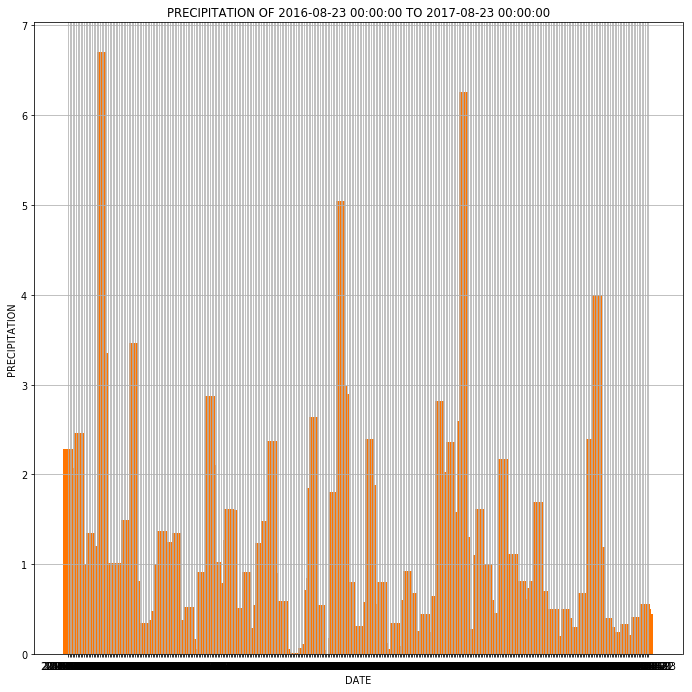

In [18]:
# Ploting the results as a bar chart using pandas plotting
plt.figure(figsize =(10,10), dpi=70)
plt.bar(precipitation_df['date'],precipitation_df['prcp'], width=6, alpha=1,color='#FF7500')
plt.grid()
plt.title(f'PRECIPITATION OF {startDate} TO {endDate}')
plt.xlabel('DATE')
plt.ylabel('PRECIPITATION')
plt.tight_layout()
plt.show()

![precipitation](../Resources/Images/precipitation.png)

### Using Pandas to calculate the summary statistics for the precipitation data

In [19]:
prcpCount = precipitation_df['prcp'].count()
# print(prcpCount)

In [20]:
prcpMean = precipitation_df['prcp'].mean()
# print(prcpMean)

In [21]:
prcpMax = precipitation_df['prcp'].max()
# print(prcpMax)

In [22]:
prcpMin = precipitation_df['prcp'].min()
# prcpMin

In [23]:
prcpStd = precipitation_df['prcp'].std()
# print(prcpStd)

In [24]:
prcpTotal = precipitation_df['prcp'].sum()/prcpCount
prcp25 = prcpTotal*0.25
prcp50 = prcpTotal*0.5
prcp75 = prcpTotal*0.75
# print(prcp25, prcp50, prcp75)

In [25]:
showResults = pd.DataFrame({" ":['COUNT','MEAN','STD','MAX','MIN','25%','50%','75%'],\
                            "PRECIPITATION ":[prcpCount,prcpMean,prcpStd,prcpMax,prcpMin,prcp25,prcp50,prcp75]})
showResults

,,PRECIPITATION
0,COUNT,2015.000000
1,MEAN,0.176462
2,STD,0.460288
3,MAX,6.700000
4,MIN,0.000000
5,25%,0.044115
6,50%,0.088231
7,75%,0.132346


![describe](../Resources/Images/describe.png)

## Station Analysis

In [26]:
# Design a query to show how many stations are available in this dataset
stationAvailable = session.query(Measurement.station).distinct(Measurement.station).count()
print("STATIONS AVAILABLE: ", stationAvailable)

STATIONS AVAILABLE:  9


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)
# List the stations and the counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.station))\
                 .group_by(Measurement.station)\
                 .order_by(desc(Measurement.station))\
                 .all() 
# activeStations
# Save the query results as a Pandas DataFrame to be print
activeStations_df = pd.DataFrame(activeStations, columns=['Station', 'Total Rows'])
activeStations_df

,Station,Total Rows
0,USC00519523,2669
1,USC00519397,2724
2,USC00519281,2772
3,USC00518838,511
4,USC00517948,1372
5,USC00516128,2612
6,USC00514830,2202
7,USC00513117,2709
8,USC00511918,1979


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station
# Select the most active station
mostActiveStation = activeStations_df.iloc[0,0]
print(f'MOST ACTIVE STATION: {mostActiveStation}')

MOST ACTIVE STATION: USC00519523


In [29]:
# Query to calculate the summary statistics of temperature of most activate station
summaryTemperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                     .filter(Measurement.station == mostActiveStation)\
                     .all()
# print(dataTemperature)
# Save the query results as a Pandas DataFrame to be print
summaryTemperature_df = pd.DataFrame(summaryTemperature, columns=['min','max','avg'])
print(f'TEMPERATURE SUMMARY STATISTICS OF {mostActiveStation} STATION')
print(f'LOWEST TEPERATURE: {summaryTemperature_df.iloc[0,0]}')
print(f'HIGHEST TEPERATURE: {summaryTemperature_df.iloc[0,1]}')
print(f'AVERAGE TEPERATURE: {summaryTemperature_df.iloc[0,2]}')

TEMPERATURE SUMMARY STATISTICS OF USC00519523 STATION
LOWEST TEPERATURE: 56.0
HIGHEST TEPERATURE: 85.0
AVERAGE TEPERATURE: 74.5436493068565


In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationByYear = session.query(Measurement.tobs, Measurement.date)\
            .filter(and_(Measurement.station == mostActiveStation, Measurement.date>=startDate,Measurement.date<=endDate))\
            .all()
# stationByYear

![precipitation](Images/station-histogram.png)

In [31]:
# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(stationByYear, columns=['tobs', 'date'])
# temperature_df

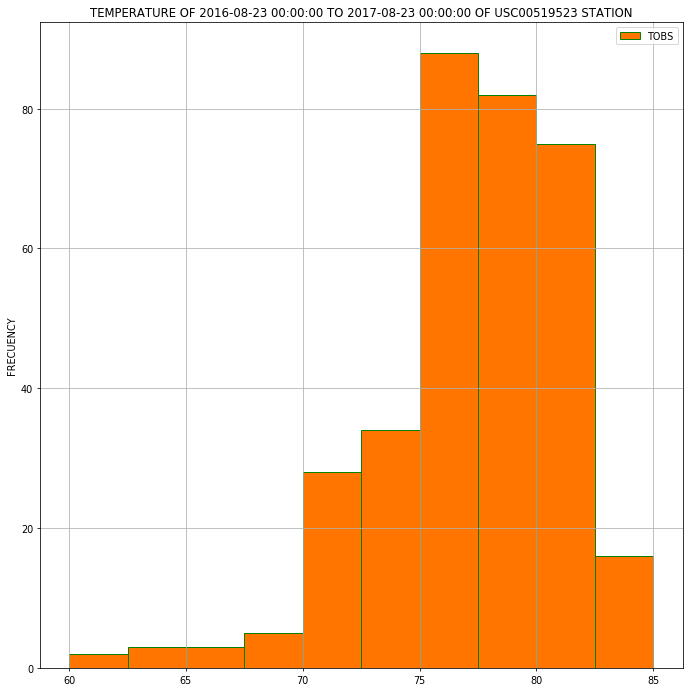

In [32]:
# Ploting the results as a histogram chart using pandas plotting
plt.figure(figsize =(10,10), dpi=70)
plt.hist(temperature_df['tobs'], facecolor='#FF7500', edgecolor='green', bins=10, label = 'TOBS')
plt.grid()
plt.title(f'TEMPERATURE OF {startDate} TO {endDate} OF {mostActiveStation} STATION')
plt.ylabel('FRECUENCY')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Temperature Analysis (Optional)

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
            .filter(Measurement.date >= start_date)\
            .filter(Measurement.date <= end_date)\
            .all()

# function usage example
print(f'FUNCTION USAGE EXAMPLE: {calc_temps("2012-02-28", "2012-03-05")}')

FUNCTION USAGE EXAMPLE: [(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calTemps = calc_temps(startDate, endDate)
print(f'FUNCTION USAGE MY TRIP: {calTemps}')

FUNCTION USAGE MY TRIP: [(58.0, 74.57894736842105, 87.0)]


In [35]:
# Plot the results from your previous query as a bar chart. 
calTemps_df = pd.DataFrame(calTemps, columns=['min','avg','max'])
x_pos = np.arange(len(calTemps))
# Use the average temperature for the y value
y_axis = [calTemps_df.iloc[0,1]]
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
errorArray = [calTemps_df.iloc[0,2],calTemps_df.iloc[0,0]]
errorArray = np.std(errorArray)
error = [errorArray]

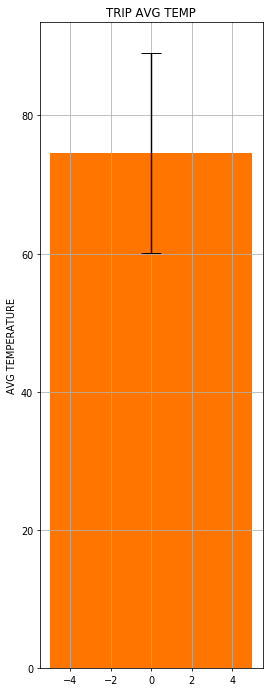

In [36]:
# Ploting the results as a bar chart using pandas plotting
plt.figure(figsize =(4,10), dpi=70)
plt.bar(x_pos,y_axis, yerr=error, width=10, align='center', alpha=1, ecolor='black', capsize=10,color='#FF7500')
plt.grid()
# Use "Trip Avg Temp" as your Title
plt.title('TRIP AVG TEMP')
plt.ylabel('AVG TEMPERATURE')
plt.tight_layout()
plt.show()

# Optional Challenge Assignment

### Calculate the rainfall per weather station using the previous year's matching dates.

In [37]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfallPerStation = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                                   func.avg(Measurement.prcp))\
                        .filter(and_(Measurement.date >= startDate, Measurement.date <= endDate))\
                        .filter(Station.station == Measurement.station)\
                        .group_by(Measurement.station)\
                        .order_by(desc(Measurement.prcp))\
                        .all()
#print(rainfallPerStation)
station_df = pd.DataFrame(rainfallPerStation, columns = ['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','RAINFALL'])
station_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,RAINFALL
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125720
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141404
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.194416
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.449878
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121374
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044944
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500


### Calculate the daily normals for your trip

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# function usage example
print(f'FUNCTION USAGE EXAMPLE: {daily_normals("01-01")}')

FUNCTION USAGE EXAMPLE: [(62.0, 69.15384615384616, 77.0)]


In [39]:
# Set the start and end date of the trip
startDayTrip = dt.datetime(2017,3,13,0,0,0)
totalDays = 11
# Use the start and end date to create a range of dates
daysList = []
for d in range (0, totalDays):
    daysList.append(startDayTrip + dt.timedelta(days = d))
for i in daysList:
    print(i)

2017-03-13 00:00:00
2017-03-14 00:00:00
2017-03-15 00:00:00
2017-03-16 00:00:00
2017-03-17 00:00:00
2017-03-18 00:00:00
2017-03-19 00:00:00
2017-03-20 00:00:00
2017-03-21 00:00:00
2017-03-22 00:00:00
2017-03-23 00:00:00


In [40]:
# Stip off the year and save a list of %m-%d strings
for i in range(len(daysList)):
    daysList[i] = daysList[i].strftime("%m-%d")
    print(daysList[i])

03-13
03-14
03-15
03-16
03-17
03-18
03-19
03-20
03-21
03-22
03-23


In [41]:
# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`
normals = []
for x in daysList:
    normals.append(daily_normals(x))
normals

[[(56.0, 69.29629629629629, 77.0)],
 [(62.0, 70.32758620689656, 77.0)],
 [(58.0, 68.54716981132076, 76.0)],
 [(60.0, 69.70370370370371, 78.0)],
 [(57.0, 68.54, 75.0)],
 [(57.0, 67.7843137254902, 76.0)],
 [(60.0, 69.1, 75.0)],
 [(62.0, 70.11764705882354, 80.0)],
 [(60.0, 71.07692307692308, 77.0)],
 [(65.0, 71.75471698113208, 77.0)],
 [(63.0, 70.79629629629629, 78.0)]]

In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = []
tavg = []
tmax = []
for i in range(len(normals)):
     tmin.append(normals[i][0][0])
     tavg.append(normals[i][0][1])
     tmax.append(normals[i][0][2])
tripDays_df = pd.DataFrame(list(zip(daysList,tmin,tavg,tmax)), columns=['DATE','TMIN','TAVG','TMAX'])
tripDays_df.set_index("DATE", inplace = True) 
tripDays_df

,TMIN,TAVG,TMAX
DATE,,,
03-13,56.0,69.296296,77.0
03-14,62.0,70.327586,77.0
03-15,58.0,68.547170,76.0
03-16,60.0,69.703704,78.0
03-17,57.0,68.540000,75.0
03-18,57.0,67.784314,76.0
03-19,60.0,69.100000,75.0
03-20,62.0,70.117647,80.0
03-21,60.0,71.076923,77.0


<Figure size 700x700 with 0 Axes>

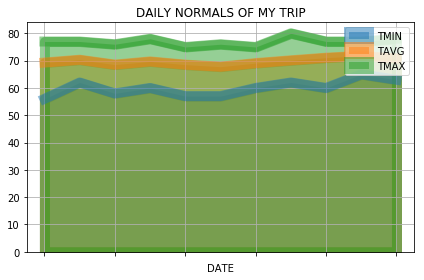

In [43]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize =(10,10), dpi=70)
tripDays_df.plot.area(stacked=False, linewidth = 10);
plt.grid()
plt.title('DAILY NORMALS OF MY TRIP')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()